In [1]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing
def prepros(train_file, test_file, ground_file):
    # read training data - It is the aircraft engine run-to-failure data.
    train_df = pd.read_csv(train_file, sep=" ", header=None)

    #remove the columns 26 and 27 because of NAN values
    train_df=train_df.loc[:,0:25]

    train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                         's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                         's15', 's16', 's17', 's18', 's19', 's20', 's21']

    train_df = train_df.sort_values(['id','cycle'])

    # read test data - It is the aircraft engine operating data without failure events recorded.
    test_df = pd.read_csv(test_file, sep=" ", header=None)

    #remove the columns 26 and 27 because of NAN values
    test_df=test_df.loc[:,0:25]

    test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                         's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                         's15', 's16', 's17', 's18', 's19', 's20', 's21']

    test_df = test_df.sort_values(['id','cycle'])

    #read ground truth data - It contains the information of true remaining cycles for each engine in the testing data.
    truth_df = pd.read_csv(ground_file, sep=" ", header=None)

    #remove the columns 1 because of NAN values
    truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)
    truth_df.columns = ['cycle']

    # Data Labeling - generate column RUL(Remaining Usefull Life or Time to Failure)
    ##TRAINING DATASET
    rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
    rul.columns = ['id', 'max']

    train_df = train_df.merge(rul, on=['id'], how='left')

    train_df['RUL'] = train_df['max'] - train_df['cycle']
    train_df.drop('max', axis=1, inplace=True)

    # generate label columns for training data
    # we will only make use of "label1" for binary classification, 
    # while trying to answer the question: is a specific engine going to fail within w1 cycles?
    w1 = 30
    w0 = 15
    train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )

    train_df['label2'] = train_df['label1']
    train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

    #check columns with repeated values: setting3, s1, s5, s10, s16,s18,s19
    train_df.apply(lambda x: x.nunique())
    train_df.drop(train_df.columns[[4,5,9,14,20,22,23]], axis=1, inplace=True)

    #TEST DATASET
    test_df.drop(test_df.columns[[4,5,9,14,20,22,23]], axis=1, inplace=True)
    test_df.apply(lambda x: x.nunique())

    # We use the ground truth dataset to generate labels for the test data.
    # generate column max for test data
    rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()

    rul.columns = ['id', 'max']
    truth_df.columns = ['more']
    truth_df['id'] = truth_df.index + 1
    truth_df['max'] = rul['max'] + truth_df['more']
    truth_df.drop('more', axis=1, inplace=True)

    # generate RUL for test data
    test_df = test_df.merge(truth_df, on=['id'], how='left')
    test_df['RUL'] = test_df['max'] - test_df['cycle']
    test_df.drop('max', axis=1, inplace=True)

    # generate label columns w0 and w1 for test data
    test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
    test_df['label2'] = test_df['label1']
    test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

    # MinMax normalization (from 0 to 1)
    min_max_scaler = preprocessing.MinMaxScaler()

    ###TRAIN#####
    train_df['cycle_norm'] = train_df['cycle']
    cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
    norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                                 columns=cols_normalize, 
                                 index=train_df.index)

    join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
    train_df = join_df.reindex(columns = train_df.columns)

    ####TEST#####
    test_df['cycle_norm'] = test_df['cycle']
    test_df['id_norm'] = test_df['id']
    norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                                columns=cols_normalize, 
                                index=test_df.index)
    test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
    test_df = test_join_df.reindex(columns = test_df.columns)
    test_df = test_df.reset_index(drop=True)

    #### Generating input data
    # pick the feature columns 
    sequence_cols = train_df.columns.difference(['id','cycle','RUL','label1','label2'])

    # generate sequences and convert to numpy array
    X_train = train_df[sequence_cols]

    #obtain the last cycle data for each test battery
    test_df=test_df.loc[test_df.groupby('id').cycle.idxmax()]
    X_test = test_df[sequence_cols]
    # Generate labels
    y_train=train_df['RUL']
    y_test=test_df['RUL']
    return (X_train, y_train, X_test, y_test)

In [2]:
X_train_1, y_train_1, X_test_1, y_test_1 = prepros('train_FD001.txt', 'test_FD001.txt', 'RUL_FD001.txt')
X_train_2, y_train_2, X_test_2, y_test_2 = prepros('train_FD002.txt', 'test_FD002.txt', 'RUL_FD002.txt')
X_train_3, y_train_3, X_test_3, y_test_3 = prepros('train_FD003.txt', 'test_FD003.txt', 'RUL_FD003.txt')
X_train_4, y_train_4, X_test_4, y_test_4 = prepros('train_FD004.txt', 'test_FD004.txt', 'RUL_FD004.txt')

/Users/divishrengasamy/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/divishrengasamy/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/divishrengasamy/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/divishrengasamy/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [3]:
# #Hyperparameter optimization
para1 = {'C': [1, 10, 100, 1000], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid' ],'epsilon':  [0.0001,0.001,0.01,0.1], 'gamma':['auto', 'scale']}

svc=svm.SVR()
clf1 = GridSearchCV(svc, para1, n_jobs=-1, cv=3, verbose=1)
clf1.fit(X_train_1[0:6200],y_train_1[0:6200])
clf1.best_params_

Fitting 3 folds for each of 128 candidates, totalling 384 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 384 out of 384 | elapsed:  4.1min finished


{'C': 100, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}

In [4]:
svc=svm.SVR()
clf2 = RandomizedSearchCV(svc, para1)
clf2.fit(X_train_2[0:16127],y_train_2[0:16127])
clf2.best_params_

/Users/divishrengasamy/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'C': 1000, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'linear'}

In [5]:
svc=svm.SVR()
clf3 = RandomizedSearchCV(svc, para1)
clf3.fit(X_train_3[0:7416],y_train_3[0:7416])
clf3.best_params_

/Users/divishrengasamy/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'C': 10, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}

In [6]:
svc=svm.SVR()
clf4 = RandomizedSearchCV(svc, para1)
clf4.fit(X_train_4[0:18375],y_train_4[0:18375])
clf4.best_params_

/Users/divishrengasamy/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'C': 1000, 'epsilon': 0.001, 'gamma': 'scale', 'kernel': 'poly'}

In [7]:
def training_func(X_train_data, y_train_data, C_, epsilon_, kernel_, gamma_):
    clf=svm.SVR(C=C_, epsilon=epsilon_, kernel=kernel_, gamma=gamma_)
    start = time.time()
    clf.fit(X_train_data, y_train_data)
    end = time.time()
    training_time = end - start
    return (clf, training_time)

# def training_func(X_train_data, y_train_data):
#     clf=svm.SVR('rbf')
#     start = time.time()
#     clf.fit(X_train_data, y_train_data)
#     end = time.time()
#     training_time = end - start
#     return (clf, training_time)

In [8]:
clf_1, training_time_1 = training_func(X_train_1, y_train_1, 1, 0.1, 'rbf', 'scale')
clf_2, training_time_2 = training_func(X_train_2, y_train_2, 1000, 0.1, 'linear', 'auto')
clf_3, training_time_3 = training_func(X_train_3, y_train_3, 10, 0.1, 'rbf', 'scale')
clf_4, training_time_4 = training_func(X_train_4, y_train_4, 1000, 0.001, 'poly', 'scale')

# clf_1, training_time_1 = training_func(X_train_1, y_train_1)
# clf_2, training_time_2 = training_func(X_train_2, y_train_2)
# clf_3, training_time_3 = training_func(X_train_3, y_train_3)
# clf_4, training_time_4 = training_func(X_train_4, y_train_4)

In [13]:
y_pred_1 = clf_1.predict(X_test_1)
y_pred_2 = clf_2.predict(X_test_2)
y_pred_3 = clf_3.predict(X_test_3)
y_pred_4 = clf_4.predict(X_test_4)

In [14]:
# Plot in blue color the predicted data and in green color the
# actual data to verify visually the accuracy of the model.
def plot_pred(y_pred, y_test):
    fig_verify = plt.figure(figsize=(10, 5))
    plt.plot(y_pred, color="blue")
    plt.plot(y_test.values, color="green")
    plt.title('prediction')
    plt.ylabel('value')
    plt.xlabel('row')
    plt.legend(['predicted', 'actual data'], loc='upper left')
    plt.show()
    fig_verify.savefig("model_RF_verify.png")

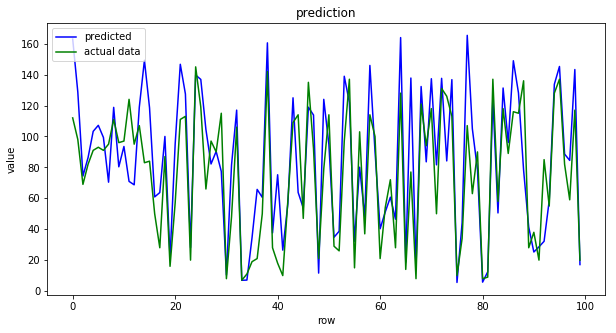

In [15]:
plot_pred(y_pred_1, y_test_1)

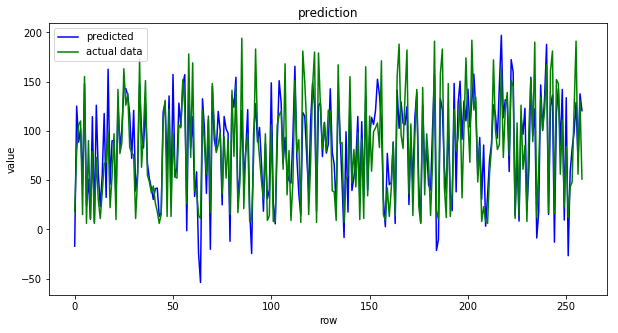

In [16]:
plot_pred(y_pred_2, y_test_2)

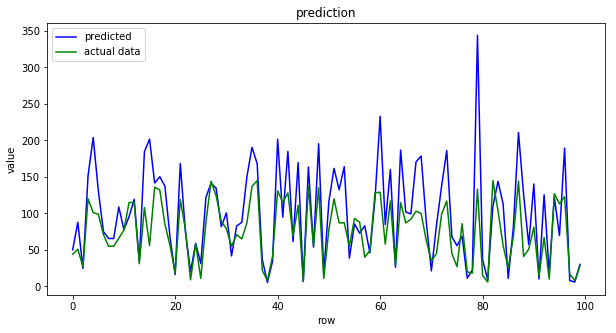

In [17]:
plot_pred(y_pred_3, y_test_3)

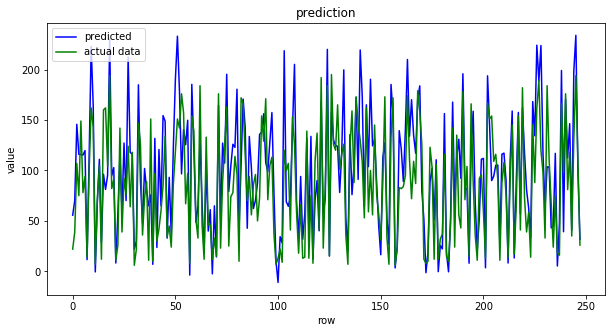

In [18]:
plot_pred(y_pred_4, y_test_4)

In [19]:
def scoring_function(true, pred):
    d = pred - true
    length = len(d)
    s = 0
    for i in range(length):
        if (d[i] < 0):
            s += np.exp((-d[i]/10))-1
        else:
            s += np.exp((d[i]/13))-1
    return s


def rmse(true, pred):
    d_squared = (pred - true)**2
    err = np.mean(d_squared)
    err = np.sqrt(err)
    return err


def mae(true,pred):
    d=abs(pred - true)
    err=np.mean(d)
    return err

y_test = [y_test_1.values,y_test_2.values,y_test_3.values,y_test_4.values]
y_pred = [y_pred_1,y_pred_2,y_pred_3,y_pred_4]

# y_test = [y_test_1.values]
# y_pred = [y_pred_1]


sf_all = [scoring_function(test,pred) for test, pred in zip(y_test, y_pred)]
rmse_all = [rmse(test,pred) for test, pred in zip(y_test, y_pred)]
mae_all = [mae(test,pred) for test, pred in zip(y_test, y_pred)]
cor_all =[np.corrcoef(test, pred) for test, pred in zip(y_test, y_pred)]
all_training_time = [training_time_1,training_time_2,training_time_3,training_time_4]
#all_training_time = [training_time_1]

In [20]:
d = {'Scoring Function': sf_all, 'RMSE': rmse_all, 'MAE':mae_all, 'Correlation':cor_all, 'Training Time': all_training_time}
def final_results(d):
    df = pd.DataFrame(data=d)
    df.index += 1
    df.index.name='CMAPSS Dataset'
    return df

final_results(d)

,Correlation,MAE,RMSE,Scoring Function,Training Time
CMAPSS Dataset,,,,,
1,"[[1.0, 0.8462583935669566], [0.846258393566956...",19.706946,25.523428,1.877612e+03,20.011164
2,"[[1.0, 0.8323921664388078], [0.832392166438807...",24.528149,30.320256,1.789860e+04,141.972774
3,"[[1.0, 0.8313284338495142], [0.831328433849514...",30.930429,45.475042,1.116943e+07,33.288886
4,"[[1.0, 0.8096271182121927], [0.809627118212192...",29.348258,37.296328,3.486466e+04,159.208015


In [ ]:
X_train_4

In [ ]:
61249*0.3